# **CHPATER 3**
# **Classification**

## **Set up**

In [1]:
import sklearn
assert sklearn.__version__ >= "0.20"

import os
import numpy as np
import pandas as pd
import warnings

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)



warnings.filterwarnings('ignore')

## **MNIST Data**

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
mnist['data'].head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X, y = mnist['data'], mnist['target']
print('X.shape:', X.shape)
print('y.shape:', y.shape)

X.shape: (70000, 784)
y.shape: (70000,)


Display one digit image

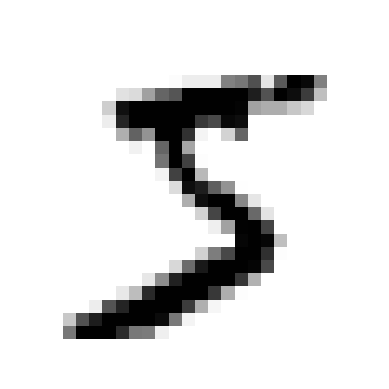

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0,:]
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [7]:
y.iloc[0]

'5'

In [8]:
# cast y from string to integer
y = y.astype(np.uint8)

Train test split the dataset

In [9]:
X_train, X_test = X.iloc[:60000,:], X.iloc[60000:,:]
y_train, y_test = y.iloc[:60000], y.iloc[60000:]

## **Train a Binary Classifier**

Training a Stochastic Gradient Descent classifier

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, shuffle=True, n_jobs=-1)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(n_jobs=-1, random_state=42)

Make prediction on `some_digit`.

In [12]:
sgd_clf.predict([some_digit])

array([ True])

## **Performance Measures**

### Measuring Accuracy Using Cross-Validation

In [13]:
# Implementating Cross-Validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)

    X_train_folds, y_train_folds = X_train.loc[train_index,:], y_train_5.loc[train_index]
    X_test_fold, y_test_fold = X_train.loc[test_index,:], y_train_5.loc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)

    print(n_correct/len(y_test_fold))


0.95035
0.96035
0.9604


Using `cross_val_score` from sklearn.

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy', n_jobs=-1)

array([0.95035, 0.96035, 0.9604 ])

Accuracy is a window-dressing measure when it comes to classification.

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy', n_jobs=-1)

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

Let not be confused by the Confusion Matrix

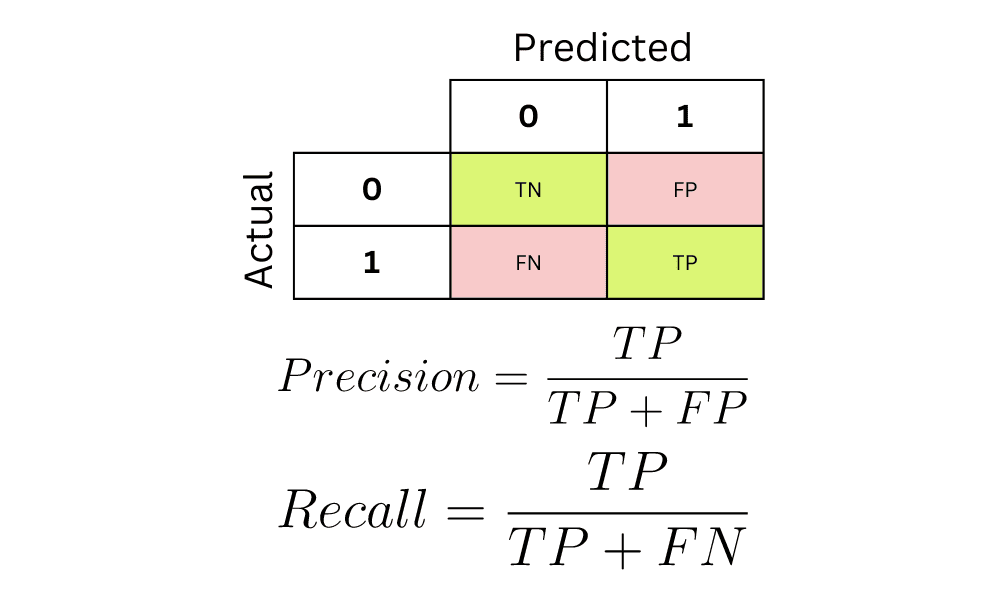

In [17]:
from IPython.display import Image
Image(os.path.join(IMAGES_PATH, 'confusion_matrix_precision_and_recall.png'))

In a confusion matrix, each row represents actual class, while each column represents a predicted class.

A perfect confusion matrix should look like.

In [18]:
from sklearn.metrics import confusion_matrix
y_train_prefect_predictions = y_train_5
confusion_matrix(y_true=y_train_5, y_pred=y_train_prefect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [19]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X=X_train, y=y_train_5, cv=3, n_jobs=-1)

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=y_train_5, y_pred=y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

### Precision and Recall
The precision measures the accuracy of the positive predictions.\
The recall measures the ratio of the positive instances that are correctly detected by the classifier.

In [21]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_true=y_train_5, y_pred=y_train_pred)
recall  = recall_score(y_true=y_train_5, y_pred=y_train_pred)
print('precision:', precision)
print('recall:', recall)

precision: 0.8370879772350012
recall: 0.6511713705958311


Compute the `F_1 score`.\
The `F_1 score` is the harmonic mean between the `precision` and the `recall`.

In [22]:
from sklearn.metrics import f1_score
f1_score_ = f1_score(y_true=y_train_5, y_pred=y_train_pred)
print('f1_score:', f1_score_)

f1_score: 0.7325171197343847


### Precision/Recall Trade-off

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
print('y_scores:', y_scores)

threshold = 0.0
y_some_digit_pred = [y_scores > threshold]
print('y_some_digit_pred:', y_some_digit_pred)

y_scores: [2164.22030239]
y_some_digit_pred: [array([ True])]


In [24]:
some_digits = X.iloc[:4,:]
y_scores = sgd_clf.decision_function(some_digits)
print('y_scores:', y_scores)

threshold = 0.0
y_some_digits_pred = [y_scores > threshold]
print('y_some_digits_pred:', y_some_digits_pred)
print('y_train of some_digits:', list(y_train[:4]))

y_scores: [  2164.22030239  -5897.37359354 -13489.14805779  -4623.84515943]
y_some_digits_pred: [array([ True, False, False, False])]
y_train of some_digits: [5, 0, 4, 1]


Computing the score of each instance in the training dataset using `cross_val_predict`.

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function', n_jobs=-1)

Compute precision and recall for all possible thresholds.

In [26]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_true=y_train_5, probas_pred=y_scores)

In [27]:
len(precisions), len(recalls), len(thresholds)

(60001, 60001, 60000)

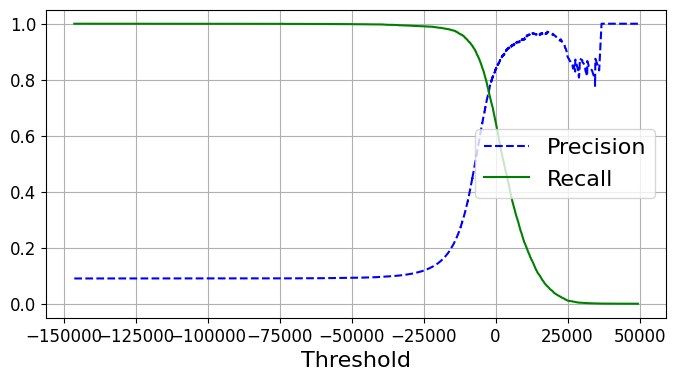

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 4)) 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Plot `precision` vs `recall`.

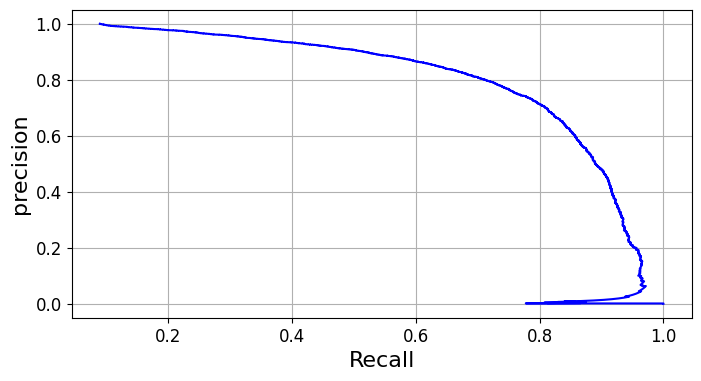

In [29]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(precisions, recalls, "b-", label="Precision")
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("precision", fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 4)) 
plot_precision_vs_recall(precisions, recalls)
plt.show()


What is the indice from which the precision goes above 90%?

In [30]:
np.argmax(precisions>=0.9)

np.int64(57109)

In [32]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.9)]
print('threshold_90_precision:', threshold_90_precision)

threshold_90_precision: 3370.0194991439557


In [35]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score_ = precision_score(y_true=y_train_5, y_pred=y_train_pred_90)
recall_score_ = recall_score(y_true=y_train_5, y_pred=y_train_pred_90)

print('precision_score:', precision_score_)
print('recall_score:', recall_score_)

precision_score: 0.9000345901072293
recall_score: 0.4799852425751706


### The ROC Curve

In [37]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

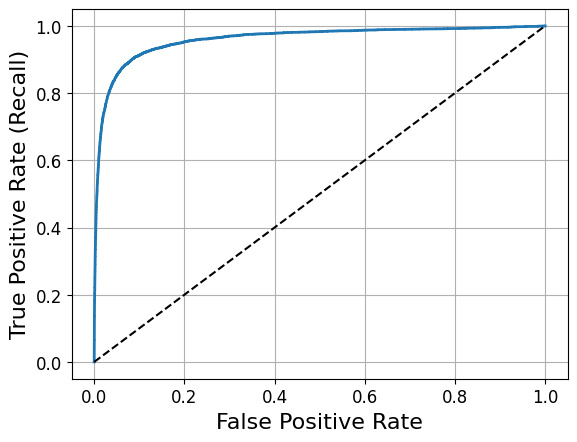

In [39]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate", fontsize=16)
    plt.ylabel("True Positive Rate (Recall)", fontsize=16)
    plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()

The area under the curve is used to compare two classifier. The one with the highest value and closer to 1 is better.

In [40]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true=y_train_5, y_score=y_scores)

np.float64(0.9604938554008616)